### Opening and analysing single day of a feature

In [59]:
import xarray as xr

# Open the NetCDF file
file_path = './features/densidade_flashes/2021/GLM_2021_12_17.nc'
ds = xr.open_dataset(file_path)

# Display the contents of the dataset
print(ds)

# Display the contents of a single variable
#print(ds['CMI_2021_12_17_00_00'].values)

<xarray.Dataset>
Dimensions:           (dim_0_2021_12_17_00_00: 94, dim_1_2021_12_17_00_00: 121,
                       dim_0_2021_12_17_00_30: 94, dim_1_2021_12_17_00_30: 121,
                       dim_0_2021_12_17_01_00: 94, dim_1_2021_12_17_01_00: 121,
                       dim_0_2021_12_17_01_30: 94, dim_1_2021_12_17_01_30: 121,
                       dim_0_2021_12_17_02_00: 94, dim_1_2021_12_17_02_00: 121,
                       dim_0_2021_12_17_02_30: 94, dim_1_2021_12_17_02_30: 121,
                       ...
                       dim_0_2021_12_17_21_00: 94, dim_1_2021_12_17_21_00: 121,
                       dim_0_2021_12_17_21_30: 94, dim_1_2021_12_17_21_30: 121,
                       dim_0_2021_12_17_22_00: 94, dim_1_2021_12_17_22_00: 121,
                       dim_0_2021_12_17_22_30: 94, dim_1_2021_12_17_22_30: 121,
                       dim_0_2021_12_17_23_00: 94, dim_1_2021_12_17_23_00: 121,
                       dim_0_2021_12_17_23_30: 94, dim_1_2021_12_17_23_30: 1

Text(0, 0.5, 'Latitude')

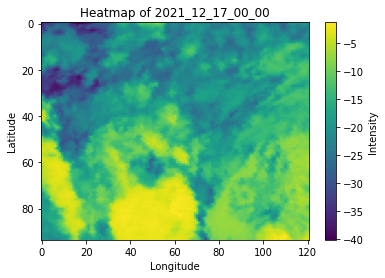

In [2]:
import matplotlib.pyplot as plt

# Plot data from CMI_2021_12_17_00_00
data_values = ds['CMI_2021_12_17_00_00'].values
plt.imshow(data_values, cmap='viridis', aspect='auto')  # You can choose a different colormap, like 'inferno' or 'plasma'
plt.colorbar(label='Intensity')  # Add color bar to show the scale of values
plt.title('Heatmap of 2021_12_17_00_00')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### Moving data from old dataset to a new one with better format

In [3]:
import xarray as xr
import numpy as np
import re

# Open the NetCDF file
file_path = './features/profundidade_nuvens/2021/PN_2021_12_17.nc'
ds = xr.open_dataset(file_path)

# Create the new empty dataset with the correct dimensions for 'lat' and 'lon'
new_ds = xr.Dataset(
    {
        "data": (("time", "lat", "lon"), np.empty((0, 94, 121))),
    },
    coords={
        "lat": np.arange(94),  # Latitude indices from 0 to 93
        "lon": np.arange(121),  # Longitude indices from 0 to 120
    },
    attrs={
        "description": "Empty NetCDF file for data insertion",
    },
)

# Initialize an empty list to store timestamps
timestamps = []

# Iterate over each variable in the original dataset
for var_name in ds.variables:
    # Use regular expression to find variable names that match the pattern 'CMI_YYYY_MM_DD_HH_MM'
    match = re.search(r'CMI_(\d{4}_\d{2}_\d{2}_\d{2}_\d{2})', var_name)
    if match:
        # Extract the timestamp string from the matched pattern
        timestamp_str = match.group(1)
        
        # Convert the timestamp string to a numpy datetime64 object
        timestamp = np.datetime64(
            f"{timestamp_str[:4]}-{timestamp_str[5:7]}-{timestamp_str[8:10]}T{timestamp_str[11:13]}:{timestamp_str[14:]}"
        )
        timestamps.append(timestamp)
        
        # Get the data for this timestamp (assuming it's a 2D array of lat x lon)
        data = ds[var_name].values  # Data should be 2D (lat x lon)

        # Append the data to the new dataset, associating it with the corresponding timestamp
        new_ds = new_ds.assign(
            data=(("time", "lat", "lon"), np.concatenate([new_ds.data.values, [data]], axis=0))
        )

# Now assign the 'time' coordinate after all data has been added
new_ds.coords["time"] = ("time", timestamps)

# Print the final dataset for inspection
print(new_ds)


<xarray.Dataset>
Dimensions:  (time: 144, lat: 94, lon: 121)
Coordinates:
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 84 85 86 87 88 89 90 91 92 93
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 113 114 115 116 117 118 119 120
  * time     (time) datetime64[ns] 2021-12-17T01:30:00 ... 2021-12-17T22:50:00
Data variables:
    data     (time, lat, lon) float64 -23.31 -23.89 -23.89 ... -7.038 -7.038
Attributes:
    description:  Empty NetCDF file for data insertion


### Moving data from old dataset to a new one with better format (with all features)

In [148]:
import xarray as xr
import numpy as np
import re
import os
from glob import glob
import pandas as pd  # Needed for handling duplicate timestamps

base_path = './features'

# Output dimensions
lat_dim, lon_dim = 94, 121

# Creating an empty dataset
combined_ds = xr.Dataset(
    {
        "data": (("time", "lat", "lon", "channel"), np.empty((0, lat_dim, lon_dim, 0))),
    },
    coords={
        "lat": np.arange(lat_dim),
        "lon": np.arange(lon_dim),
        "channel": [],
    },
    attrs={
        "description": "Consolidated NetCDF file with multiple features",
    },
)


def process_feature(feature_name, file_pattern):
    global combined_ds
    timestamps = []
    data_list = []

    # Find all files for the current feature
    files = sorted(glob(file_pattern))
    for file_path in files:
        ds = xr.open_dataset(file_path)

        for var_name in ds.variables:
            # Match the timestamp pattern
            match = re.search(r'(?:CMI_)?(\d{4}_\d{2}_\d{2}_\d{2}_\d{2})', var_name)

            if match:
                # Parse timestamp
                timestamp_str = match.group(1)
                timestamp = np.datetime64(
                    f"{timestamp_str[:4]}-{timestamp_str[5:7]}-{timestamp_str[8:10]}T{timestamp_str[11:13]}:{timestamp_str[14:]}"
                )

                minutes = int(timestamp_str[14:])
                if minutes not in [0, 30]:
                    continue  # Skip timestamps not on :00 or :30

                timestamps.append(timestamp)

                # Extract data and ensure it matches the required shape
                data = ds[var_name].values  # Shape: (lat, lon)
                if data.shape != (lat_dim, lon_dim):
                    raise ValueError(f"Unexpected data shape: {data.shape}")

                # Add data to the list
                data_list.append(data)

    if data_list:
        # Stack data along the time dimension
        feature_data = np.stack(data_list, axis=0)  # Shape: (time, lat, lon)

        # Expand to include the channel dimension
        feature_data = np.expand_dims(feature_data, axis=-1)  # Shape: (time, lat, lon, 1)

        # Create a dataset for this feature
        feature_ds = xr.Dataset(
            {
                "data": (("time", "lat", "lon", "channel"), feature_data),
            },
            coords={
                "time": timestamps,
                "lat": np.arange(lat_dim),
                "lon": np.arange(lon_dim),
                "channel": [feature_name],
            },
        )

        # Merge this feature's dataset with the combined dataset
        if combined_ds.dims["time"] == 0:  # If combined_ds is still empty
            combined_ds = feature_ds
        else:
            # Align time and concatenate along the channel dimension
            combined_ds = xr.concat([combined_ds, feature_ds], dim="channel")


# Process each feature
for feature_name in sorted(glob(f"{base_path}/*")):
    if os.path.isdir(feature_name):
        feature_name_short = os.path.basename(feature_name)
        file_pattern = f"{feature_name}/**/*.nc"
        process_feature(feature_name_short, file_pattern)

# Inspect the final combined dataset
print(combined_ds)

/home/raul_martino/miniconda3/envs/atmoseer/lib/python3.12/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/raul_martino/miniconda3/envs/atmoseer/lib/python3.12/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/raul_martino/miniconda3/envs/atmoseer/lib/python3.12/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a 

<xarray.Dataset>
Dimensions:  (time: 96, lat: 94, lon: 121, channel: 5)
Coordinates:
  * time     (time) datetime64[ns] 2021-12-17 ... 2021-12-26T23:30:00
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 84 85 86 87 88 89 90 91 92 93
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 113 114 115 116 117 118 119 120
  * channel  (channel) <U20 'densidade_flashes' ... 'tamanho_particulas'
Data variables:
    data     (time, lat, lon, channel) float64 0.0 -4.344 ... -39.45 292.7


/home/raul_martino/miniconda3/envs/atmoseer/lib/python3.12/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [149]:
# Print combined_df timestamps
print(combined_ds.time.values)

['2021-12-17T00:00:00.000000000' '2021-12-17T00:30:00.000000000'
 '2021-12-17T01:00:00.000000000' '2021-12-17T01:30:00.000000000'
 '2021-12-17T02:00:00.000000000' '2021-12-17T02:30:00.000000000'
 '2021-12-17T03:00:00.000000000' '2021-12-17T03:30:00.000000000'
 '2021-12-17T04:00:00.000000000' '2021-12-17T04:30:00.000000000'
 '2021-12-17T05:00:00.000000000' '2021-12-17T05:30:00.000000000'
 '2021-12-17T06:00:00.000000000' '2021-12-17T06:30:00.000000000'
 '2021-12-17T07:00:00.000000000' '2021-12-17T07:30:00.000000000'
 '2021-12-17T08:00:00.000000000' '2021-12-17T08:30:00.000000000'
 '2021-12-17T09:00:00.000000000' '2021-12-17T09:30:00.000000000'
 '2021-12-17T10:00:00.000000000' '2021-12-17T10:30:00.000000000'
 '2021-12-17T11:00:00.000000000' '2021-12-17T11:30:00.000000000'
 '2021-12-17T12:00:00.000000000' '2021-12-17T12:30:00.000000000'
 '2021-12-17T13:00:00.000000000' '2021-12-17T13:30:00.000000000'
 '2021-12-17T14:00:00.000000000' '2021-12-17T14:30:00.000000000'
 '2021-12-17T15:00:00.000

### Collecting the samples after combined_ds is generated

In [150]:
# Define constants for the sampling process
TIMESTEP = 5  # Number of timesteps in each sample
MAX_GAP = 30  # Maximum allowed gap (in minutes)

# Function to check for maximum gap within a sample
def check_max_gap(timestamps):
    """Check the maximum time difference (gap) in minutes within a sample."""
    time_deltas = timestamps.diff(dim="time") / np.timedelta64(1, "m")  # Convert to minutes
    max_gap = time_deltas.max().item() if len(time_deltas) > 0 else 0
    return max_gap

# Function to collect samples
def collect_samples(dataset, timestep, max_gap):
    """Collect valid X_samples and Y_samples from the dataset."""
    X_samples, Y_samples = [], []
    times = dataset.time  # Keep as xarray.DataArray to use diff()
    
    # Iterate through the dataset in sliding windows
    for i in range(len(times) - timestep):
        
        time_window_x = times.isel(time=slice(i, i + timestep))
        time_window_y = times.isel(time=slice(i + 1, i + timestep + 1))

        # Check for gaps in X_sample's time window
        if check_max_gap(time_window_x) > max_gap:
            continue  # Skip samples with large gaps
        
        # Extract X and Y samples
        X_sample = dataset.isel(time=slice(i, i + timestep)).data
        Y_sample = dataset.isel(time=slice(i + 1, i + timestep + 1)).data

        X_samples.append(X_sample)
        Y_samples.append(Y_sample)
    
    return X_samples, Y_samples

# Collect samples
X_samples, Y_samples = collect_samples(combined_ds, TIMESTEP, MAX_GAP)

# Inspect results
print(f"Collected {len(X_samples)} valid samples.")


Collected 87 valid samples.


In [155]:
import xarray as xr
import numpy as np

# Convert X_samples and Y_samples to numpy arrays
X_array = np.stack(X_samples)  # Shape: (samples, time, lat, lon, channel)
Y_array = np.stack(Y_samples)  # Shape: (samples, time, lat, lon, channel)

# Extract coordinates from the dataset (assumindo que as dimensões estão em combined_ds)
lat = combined_ds.lat.values
lon = combined_ds.lon.values
# time = combined_ds.time[:X_array.shape[1]].values  # Timestamps para a dimensão 'time'
channel = combined_ds.channel.values if "channel" in combined_ds else [0]  # Caso exista 'channel'

# Define o índice de samples
sample = np.arange(X_array.shape[0])  # Sample indices

# Cria o xarray.Dataset
output_ds = xr.Dataset(
    {
        "x": (["sample", "time", "lat", "lon", "channel"], X_array),
        "y": (["sample", "time", "lat", "lon", "channel"], Y_array),
    },
    coords={
        # "sample": sample,
        # "time": time,
        "lat": lat,
        "lon": lon,
        # "channel": channel,
    },
    attrs={
        "description": "The variables have weather features values and are separable in x and y, "
                       "which are to be used as input and target of the machine learning algorithms, respectively."
    },
)

# Salva o dataset em um arquivo NetCDF
# output_ds.to_netcdf("output_dataset.nc")
print("Dataset salvo como 'output_dataset.nc'")

Dataset salvo como 'output_dataset.nc'


In [156]:
output_ds

<xarray.Dataset>
Dimensions:  (sample: 87, time: 5, lat: 94, lon: 121, channel: 5)
Coordinates:
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 84 85 86 87 88 89 90 91 92 93
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 113 114 115 116 117 118 119 120
Dimensions without coordinates: sample, time, channel
Data variables:
    x        (sample, time, lat, lon, channel) float64 0.0 -4.344 ... 292.6
    y        (sample, time, lat, lon, channel) float64 0.0 -3.882 ... 292.7
Attributes:
    description:  The variables have weather features values and are separabl...

In [154]:
compare_ds = xr.open_dataset('dataset-chirps-1981-2019-seq5-ystep5.nc')
compare_ds

<xarray.Dataset>
Dimensions:  (lat: 50, lon: 50, sample: 13960, time: 5, channel: 1)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: sample, time, channel
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...

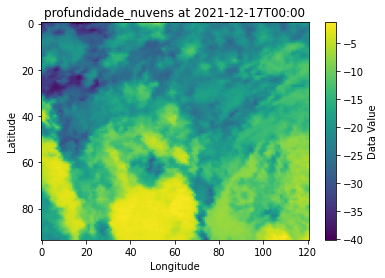

In [8]:
import matplotlib.pyplot as plt

# Convert the timestamp string to np.datetime64
target_timestamp = np.datetime64("2021-12-17T00:00")

# Extract data for the specific channel and timestamp
feature_name = "profundidade_nuvens"
channel_index = np.where(combined_ds.coords['channel'].values == feature_name)[0][0]

# Find the index of the target timestamp
time_index = np.where(combined_ds.coords['time'].values == target_timestamp)[0][0]

# Get the data for that timestamp
data_at_timestamp = combined_ds["data"].isel(time=time_index, channel=channel_index)

# Plotting
plt.imshow(data_at_timestamp, cmap='viridis', aspect='auto')
plt.colorbar(label='Data Value')
plt.title(f"{feature_name} at {target_timestamp}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


#### Making sure the data is intact

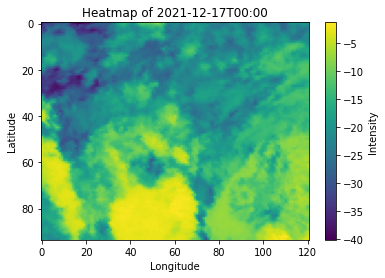

In [4]:
target_timestamp = np.datetime64("2021-12-17T00:00")
data = new_ds.sel(time=target_timestamp).data

# Plot the data for the target timestamp
plt.imshow(data, cmap='viridis', aspect='auto')
plt.colorbar(label='Intensity')
plt.title(f'Heatmap of {target_timestamp}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()